# Revisit all permutations sound paradigm with the new metrics
The last iteration of my experiments have used an stimulation paramete which I have called triplet
(three sound fragments coming from the same source) which enables the comparison between sounds with multiple
degrees of difference. This however limits the diversity of sounds used for stimulation. In the past
I have used four different sounds and consider all the permutations between them used as context and probes
This was somewhat replaced by the triplets approach, but keep recording some data with this paradigm.

It is time to analyse this data with the latest metrics for contextual effects: significant absolute sum
and significant absolute mass center

furthermore, since the all permutations dataset has a "balanced" number of trials for al combinations of contexts and
probes, it enables running the dPCA algorithm not only using the context as a category for a given probe
(probewise dPCA or pdPCA), bur rather using all the contexts and probes simultaneously (full dPCA or fdPCA) as two
different categories.

This in particular gives us  multiple marginalizations (the projections on different subspaces) that better explain
variance across contexts, probes, or the interaction of both.

to do:
1. load DF, check general distribution of cells in paramter space


In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, fixed

import src.visualization.fancy_plots as fplt
from src.data.cache import set_name
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
import src.data.dPCA as cdPCA
from src.data.load import load
from src.metrics.dprime import flip_dprimes

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2020-11-19 201550.log


In [13]:
plt.style.use('dark_background')
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }
plt.rcParams.update(params)


# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a', '#a65628',
#                   '#984ea3', '#999999', '#e41a1c', '#dede00']

trans_color_map = {0: '#377eb8',  # blue
                   1: '#ff7f00',  # orange
                   2: '#4daf4a',  # green
                   3: '#a65628', # brown
                   4: '#984ea3'}  # brown

prob_style_map = {1: '-',
                  2: '--',
                  3: ':',
                  4: '-.'}

In [3]:
# imports preproced data and metric array

config = ConfigParser()
config.read_file(open(pl.Path().cwd().parent / 'config' / 'settings.ini'))

meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': [0, 1, 2, 3, 4],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None}

In [4]:
# loads the summary metrics
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / 'prm_summary_DF_v2' / set_name(meta)

DF = jl.load(summary_DF_file)

#create the id_probe pair for
DF['id_probe'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id_probe', 'probe']].agg('_'.join, axis=1)

In [5]:
print(DF.columns)
print(DF.head(5))

Index(['analysis', 'cellid', 'goodness', 'parameter', 'probe', 'siteid',
       'source', 'std', 'transition_pair', 'value', 'region', 'id_probe'],
      dtype='object')
  analysis        cellid  goodness parameter    probe   siteid  source  \
0       SC  CRD002a-01-2  0.097988        r0  probe_1  CRD002a  dprime   
1       SC  CRD002a-01-2  0.097988       tau  probe_1  CRD002a  dprime   
2       SC  CRD002a-01-2       NaN       max  probe_1  CRD002a  dprime   
3       SC  CRD002a-01-2       NaN  integral  probe_1  CRD002a  dprime   
4       SC  CRD002a-01-2       NaN       sum  probe_1  CRD002a  dprime   

          std transition_pair       value region              id_probe  
0    0.212862             0_1    0.658246     A1  CRD002a-01-2_probe_1  
1  817.003385             0_1  420.820359     A1  CRD002a-01-2_probe_1  
2         NaN             0_1    1.656879     A1  CRD002a-01-2_probe_1  
3         NaN             0_1  270.602423     A1  CRD002a-01-2_probe_1  
4         NaN       

In [6]:
# load digested data
rec_recache = False
all_probes = [1, 2, 3, 4]

# load the calculated dprimes and montecarlo shuffling/simulations
# the loadede dictionary has 3 layers, analysis, value type and cell/site
batch_dprime_file = pl.Path(config['paths']['analysis_cache']) / 'prm_dprimes_v2' / set_name(meta)
batch_dprimes = jl.load(batch_dprime_file)

sites = set(batch_dprimes['pdPCA']['dprime'].keys())
all_cells = set(batch_dprimes['SC']['dprime'].keys())

In [7]:
# some small preprocessing of the digested data.
# defines a significant threshold and transform the pvalues into boolean (significant vs nonsignificant)
threshold = 0.01
for analysis_name, mid_dict in batch_dprimes.items():
    mid_dict['significance'] = {key: (val <= threshold) for key, val in mid_dict['pvalue'].items()}

# set up the time bin labels in milliseconds, this is critical for plotting and calculating the tau
nbin = np.max([value.shape[-1] for value in batch_dprimes['SC']['dprime'].values()])
fs = meta['raster_fs']
times = np.linspace(0, nbin / fs, nbin, endpoint=False) * 1000

bar_width = 1 / fs * 1000
fig_root = 'single_cell_context_dprime'

In [8]:
# functions taken/modified from 200221_exp_fit_SC_dPCA_LDA_examples.py

def analysis_steps_plot(id, probe, source):
    site = id[:7] if source == 'SC' else id

    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=False)
    sig = recs['perm0']['resp']
    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    if source in ['SC', 'pdPCA']:
        raw_data_probe = probe
    elif source == 'fdPCA':
        raw_data_probe = all_probes

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, raw_data_probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')
    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)

    if source != 'fdPCA':
        trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out singleton probe dimension

    # calculates dPCA projections, either probewise or full
    if source in ['pdPCA', 'fdPCA']:
        _, projection, _ = cdPCA._cpp_dPCA(R, trialR)
        projection = projection['ct'][:, 0, ...]

        if source == 'fdPCA':
            projection = projection[:,:,all_probes.index(probe),:]

    if meta['zscore'] is False:
        trialR = trialR * meta['raster_fs']
        if source in ['pdPCA', 'fdPCA']:
            projection = projection * meta['raster_fs']

    # flips signs of dprimes and montecarlos as needed
    dprimes, shuffleds = flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')

    t = times[:trialR.shape[-1]]
    fig, axes = plt.subplots(2, 10, sharex='all', sharey='row')

    #  PSTH
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        t0_idx = meta['transitions'].index(trans[0])
        t1_idx = meta['transitions'].index(trans[1])

        if source == 'SC':
            cell_idx = goodcells.index(id)
            axes[0, tt].plot(t, trialR[:, cell_idx, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]],
                             linewidth=3)
            axes[0, tt].plot(t, trialR[:, cell_idx, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]],
                             linewidth=3)
        else:
            axes[0, tt].plot(t, projection[:, t0_idx, :].mean(axis=0), color=trans_color_map[trans[0]], linewidth=3)
            axes[0, tt].plot(t, projection[:, t1_idx, :].mean(axis=0), color=trans_color_map[trans[1]], linewidth=3)

    # Raster, dprime, CI
    bottom, top = axes[0, 0].get_ylim()
    half = ((top - bottom) / 2) + bottom
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt

        if source == 'SC':
            # raster
            cell_idx = goodcells.index(id)
            t0_idx = meta['transitions'].index(trans[0])
            t1_idx = meta['transitions'].index(trans[1])

            _ = fplt._raster(t, trialR[:, cell_idx, t0_idx, :], y_offset=0, y_range=(bottom, half), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[0]], 'alpha': 0.4, 's': 10})
            _ = fplt._raster(t, trialR[:, cell_idx, t1_idx, :], y_offset=0, y_range=(half, top), ax=axes[0, tt],
                             scatter_kws={'color': trans_color_map[trans[1]], 'alpha': 0.4, 's': 10})

        # plots the real dprime and the shuffled dprime ci
        axes[1, tt].plot(t, dprimes[prb_idx, pair_idx, :], color='white')
        _ = fplt._cint(t, shuffleds[:, prb_idx, pair_idx, :], confidence=0.95, ax=axes[1, tt],
                       fillkwargs={'color': 'white', 'alpha': 0.5})

    # significance bars
    ax1_bottom = axes[1, 0].get_ylim()[0]

    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        prb_idx = all_probes.index(probe)
        pair_idx = tt
        # histogram of context discrimination
        axes[1, tt].bar(t, batch_dprimes[source]['significance'][id][prb_idx, pair_idx, :],
                        width=bar_width, align='center', color='gray', edgecolor='white', bottom=ax1_bottom)

        # formats legend
        if tt == 0:
            if source == 'SC':
                axes[0, tt].set_ylabel(f'z-score')
            elif source == 'dPCA':
                axes[0, tt].set_ylabel(f'dPC')
            axes[1, tt].set_ylabel(f'dprime')
            axes[-1, tt].set_xlabel('time (ms)')

        axes[0, tt].set_title(f'C{trans[0]}_C{trans[1]}')

        for ax in np.ravel(axes):
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    return fig, axes

def non_param_example_plot(id, probe, trans_pair, source):
    """
    Plots dprime (top) and significant bins (bottom) with their fitted exponential decays. Both dprime and significant
    bins are the grand mean across all probes and context pairs for a given cell or site.
    :param id: str. cell or site id
    :param source: str. 'SC', 'dPCA', or 'LDA'
    :return: fig, axes.
    """

    # flips signs of dprimes and montecarlos as neede
    dprimes, shuffleds = flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')
    signif_bars = batch_dprimes[source]['shuffled_significance'][id]

    probe_idx = all_probes.index(probe)
    trans_pair_idx = trans_pair

    mean_dprime = dprimes[probe_idx, trans_pair_idx, :]
    mean_signif = signif_bars[probe_idx, trans_pair_idx, :]
    signif_mask = mean_signif>0

    t = times[:dprimes.shape[-1]]
    # calculates center of mass and integral
    significant_abs_mass_center = np.sum(np.abs(mean_dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean_dprime[signif_mask]))
    significant_abs_sum = np.sum(np.abs(mean_dprime[signif_mask])) * np.mean(np.diff(t))

    # fig, axes = plt.subplots(2, 1, sharex='all', sharey='all')
    fig, axes = plt.subplots()

    # plots dprime plus fit
    axes.plot(t, mean_dprime, color='white')
    axes.axhline(0, color='gray', linestyle='--')
    axes.fill_between(t, mean_dprime, 0, where=signif_mask, color='green', label=f"integral\n{significant_abs_sum:.2f} ms*d'")
    # _ = fplt.exp_decay(t, mean_dprime, ax=axes[0], linestyle='--', color='white')

    # plots confifence bins plut fit

    # ax1_bottom = axes.get_ylim()[0]
    ax1_bottom = -1
    axes.bar(t, mean_signif*0.5, width=bar_width, align='center',
                color='gray', edgecolor='white', bottom= ax1_bottom, alpha=0.8)
    # _ = fplt.exp_decay(times, mean_signif, ax=axes[1], linestyle='--', color='white')


    axes.axvline(significant_abs_mass_center, color='white', linewidth=3, linestyle='--',
                 label=f'center of mass\n{significant_abs_mass_center:.2f} ms')

    axes.legend()
    # axes[1].legend()

    # formats axis, legend and so on.

    axes.set_ylabel(f'dprime')
    axes.set_xlabel('time (ms)')

    return fig, axes

def category_summary_plot(id, source):
    """
    Plots calculated dprime, confidense interval of shuffled dprime, and histogram of significant bins, for all contexts
    and probes.
    Subplots are a grid of al combinations of probe (rows) and context pairs (columns), plus the means of each category,
    and the grand mean
    :param id: str. cell or site id
    :param source: str. 'SC', 'dPCA', or 'LDA'
    :return: fig, axes.
    """

    # flips signs of dprimes and montecarlos as neede
    dprimes, shuffleds = flip_dprimes(batch_dprimes[source]['dprime'][id],
                                          batch_dprimes[source]['shuffled_dprime'][id], flip='max')
    signif_bars = batch_dprimes[source]['shuffled_significance'][id]

    t = times[:dprimes.shape[-1]]
    fig, axes = plt.subplots(5, 7, sharex='all', sharey='all')

    # dprime and confidence interval for each probe-transition combinations
    for (pp, probe), (tt, trans) in itt.product(enumerate(all_probes),
                                                enumerate(itt.combinations(meta['transitions'], 2))):
        prb_idx = all_probes.index(probe)

        # plots the real dprime and the shuffled dprime
        axes[pp, tt].plot(t, dprimes[prb_idx, tt, :], color='white')
        _ = fplt._cint(t, shuffleds[:, prb_idx, tt, :], confidence=0.95, ax=axes[pp, tt],
                       fillkwargs={'color': 'white', 'alpha': 0.5})
    # dprime and ci for the mean across context pairs
    for pp, probe in enumerate(all_probes):
        prb_idx = all_probes.index(probe)
        axes[pp, -1].plot(t, np.mean(dprimes[prb_idx, :, :], axis=0), color='white')
        axes[pp, -1].axhline(0, color='gray', linestyle='--')

    # dprime and ci for the mean across probes
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[-1, tt].plot(t, np.mean(dprimes[:, tt, :], axis=0), color='white')
        axes[-1, tt].axhline(0, color='gray', linestyle='--')

    # significance bars for each probe-transition combinations
    bar_bottom = axes[0, 0].get_ylim()[0]
    for (pp, probe), (tt, trans) in itt.product(enumerate(all_probes),
                                                enumerate(itt.combinations(meta['transitions'], 2))):
        prb_idx = all_probes.index(probe)
        axes[pp, tt].bar(t, signif_bars[prb_idx, tt, :], width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)
        # _ = fplt.exp_decay(t, signif_bars[prb_idx, tt, :], ax=axes[2, tt])

    # significance bars for the mean across context pairs
    for pp, probe in enumerate(all_probes):
        prb_idx = all_probes.index(probe)
        axes[pp, -1].bar(t, np.mean(signif_bars[prb_idx, :, :], axis=0), width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)

    # significance bars for the mean across probes
    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[-1, tt].bar(t, np.mean(signif_bars[:, tt, :], axis=0), width=bar_width, align='center', color='gray',
                         edgecolor='white', bottom=bar_bottom)

    # cell summary mean: dprime, confidence interval
    axes[-1, -1].plot(t, np.mean(dprimes[:, :, :], axis=(0, 1)), color='white')
    axes[-1, -1].axhline(0, color='gray', linestyle='--')
    axes[-1, -1].bar(t, np.mean(signif_bars[:, :, :], axis=(0, 1)), width=bar_width, align='center', color='gray',
                     edgecolor='white', bottom=bar_bottom)

    # formats axis, legend and so on.
    for pp, probe in enumerate(all_probes):
        axes[pp, 0].set_ylabel(f'probe {probe}')
    axes[-1, 0].set_ylabel(f'probe\nmean')

    for tt, trans in enumerate(itt.combinations(meta['transitions'], 2)):
        axes[0, tt].set_title(f'{trans[0][:3]}_{trans[1][:3]}')
        axes[-1, tt].set_xlabel('time (ms)')
    axes[0, -1].set_title(f'pair\nmean')
    axes[-1, -1].set_xlabel('time (ms)')

    for ax in np.ravel(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    return fig, axes

def site_cell_summary(id):
    """
    plots a grid of subplots, each one showing the real dprime, histogram of significant bins and fitted exponential
    decay to the significant bins. Both the dprime and significant bins are the cell grand mean across probes and
    context pairs
    :param id: str. site id
    :return: fig, axes
    """

    site_cells = set([cell for cell in batch_dprimes['SC']['dprime'].keys() if cell[:7] == id])

    fig, axes = fplt.subplots_sqr(len(site_cells), sharex=True, sharey=True)
    for ax, cell in zip(axes, site_cells):
        grand_mean, _ = flip_dprimes(batch_dprimes['SC']['dprime'][cell], flip='max')
        line = np.mean(grand_mean, axis=(0, 1))
        hist = np.mean(batch_dprimes['SC']['shuffled_significance'][cell], axis=(0, 1))
        ax.plot(times[:len(line)], line, color='white')
        ax.axhline(0, color='gray', linestyle='--' )
        ax.bar(times[:len(hist)], hist, width=bar_width, align='center', color='gray', edgecolor='white',bottom=-0.5)

    return fig, axes

def dPCA_site_summary(site, probe, source, marginalizations):
    # loads the raw data
    recs = load(site, rasterfs=meta['raster_fs'], recache=rec_recache)
    sig = recs['perm0']['resp']

    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    if source == 'pdPCA':
        raw_data_probe = [probe]
    elif source == 'fdPCA':
        raw_data_probe = all_probes

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = cdPCA.raster_from_sig(sig, raw_data_probe, channels=goodcells, transitions=meta['transitions'],
                                   smooth_window=meta['smoothing_window'], raster_fs=meta['raster_fs'],
                                   zscore=meta['zscore'], part='probe')

    # trialR shape: Trial x Cell x Context x Probe x Time; R shape: Cell x Context x Probe x Time
    trialR, R, _ = cdPCA.format_raster(raster)

    if source == 'pdPCA': trialR, R = trialR.squeeze(axis=3), R.squeeze(axis=2)  # squeezes out probe
    Z, trialZ, dpca = cdPCA._cpp_dPCA(R, trialR)

    fig, axes = plt.subplots(len(marginalizations), 3, sharex='all', sharey='row', squeeze=False)

    for mm, marg in enumerate(marginalizations):

        if source  == 'pdPCA':
            means = Z[marg][:,:,None,:]
            trials = trialZ[marg][:,:,:,None,:]
        if source  == 'fdPCA':
            means = Z[marg]
            trials = trialZ[marg]

        if marg == 'pt':
            marginalization = 'probe'
        elif marg == 'ct':
            marginalization = 'context'
        elif marg == 'cpt':
            marginalization = 'interaction'
        elif marg == 't':
            marginalization = 'time'
        else:
            marginalization = marg

        for pc in range(3):  # first 3 principal components

            ax = axes[mm, pc]

            for (tt, trans), (pp, prb) in itt.product(enumerate(meta['transitions']), enumerate(raw_data_probe)):  # for each context
                ax.plot(times, means[pc, tt, pp, :], label=trans, color=trans_color_map[trans],
                        linestyle = prob_style_map[prb],linewidth=2)

            # formats axes labels and ticks
            if pc == 0 :
                ax.set_ylabel(f'{marginalization} dependent\nfiring rate (z-score)')
            if mm == 0:
                ax.set_title(f'dPC #{pc + 1}')
            elif mm == len(marginalizations)-1:
                ax.set_xlabel('time (ms)')

        # legend in last axis
        axes[-1, -1].legend(fontsize='x-large', markerscale=10,)

    return fig, ax, dpca


first explore which cells and sites have the highest value for contextual integration and duration. then uses said sites
as examples

In [9]:
# finds the unit-probe combination and site with the highest absolute integral and hopefully center of mass

ff_parameter = DF.parameter.isin(['significant_abs_sum', 'significant_abs_mass_center'])
ff_trans = DF.transition_pair != 'mean'
ff_probe = DF.probe != 'mean'

# single cell
print('\nsignle cell\n')
ff_analysis = DF.analysis=='SC'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['cellid', 'probe'], columns='parameter', values='value')
single_cell_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(5)
print(single_cell_top)

# probewise population
print('\nprobewise dPCA\n')
ff_analysis = DF.analysis=='pdPCA'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['siteid', 'probe'], columns='parameter', values='value')
pdPCA_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(5)
print(pdPCA_top)

# all probes population
print('\nfull dPCA\n')
ff_analysis = DF.analysis=='fdPCA'
filtered = DF.loc[ff_parameter & ff_analysis & ff_trans & ff_probe, :]

pivoted = filtered.pivot_table(index=['siteid', 'probe'], columns='parameter', values='value')
fdPCA_top = pivoted.sort_values(['significant_abs_sum', 'significant_abs_mass_center'], ascending=False).head(5)
print(fdPCA_top)


signle cell

parameter             significant_abs_mass_center  significant_abs_sum
cellid       probe                                                    
CRD004a-39-2 probe_4                   127.210370           453.847306
             probe_1                    84.440455           383.058747
CRD004a-64-1 probe_2                   249.999713           254.348781
CRD004a-39-2 probe_2                    63.262196           245.338403
AMT029a-51-1 probe_2                    29.606065           232.836089

probewise dPCA

parameter        significant_abs_mass_center  significant_abs_sum
siteid  probe                                                    
CRD004a probe_3                   194.447784           604.528925
        probe_1                   173.148606           558.522554
        probe_2                   194.492023           543.194610
CRD003b probe_2                   350.651872           480.285733
CRD004a probe_4                   172.547536           465.627896

full dPCA

In [10]:
# this seems to be a good example cell and corresponding site
cell = 'CRD004a-39-2'
site = 'CRD004a'
probe = 1

### analysis steps
this particula example showe a combination of probe and cell/site where the cell does not show some sharp onset contextual
effect whith a relative sort duration, wich in comparison, last much longer when looking at the population analysis.
Aditionally, here we start seen that using pdPCA or fdPCA lead to similar results in the context marginalization space.

loading recording from box
SC, CRD004a-39-2 probe 1 calc steps
loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please               

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


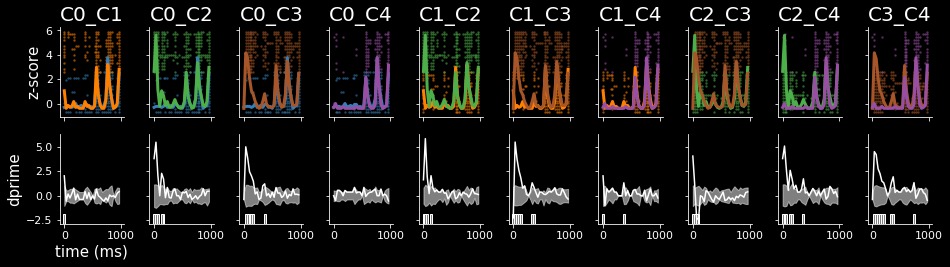

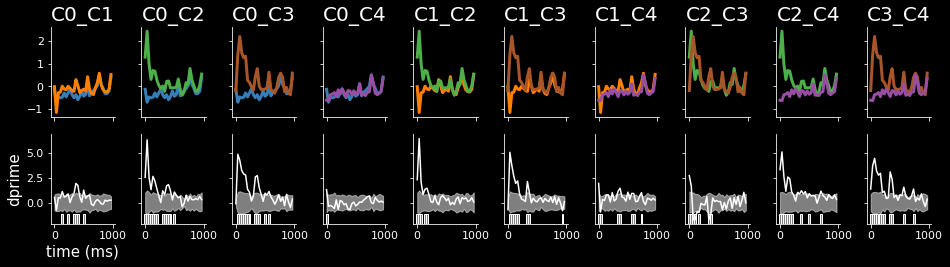

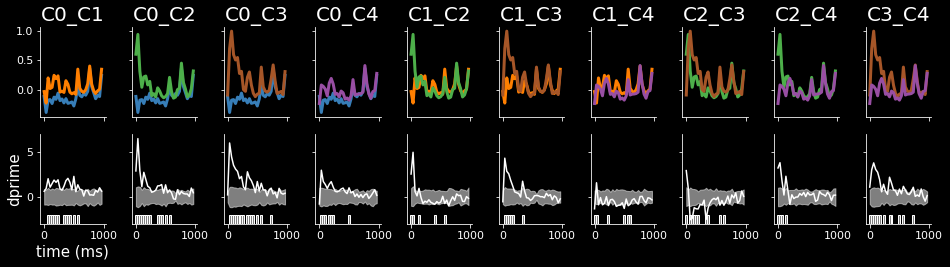

In [11]:
# SC examples
fig, axes = analysis_steps_plot(cell, probe, 'SC')
fig.set_size_inches(13.3, 3.81)
title = f'SC, {cell} probe {probe} calc steps'
print(title)
# fplt.savefig(fig, 'all_permutations', title, type='png')
plt.show()

# pdPCA examples
fig, axes = analysis_steps_plot(site, probe, 'pdPCA')
fig.set_size_inches(13.3, 3.81)
title = f'pdPCA, {site} probe {probe}, calc steps'
print(title)
# fplt.savefig(fig, 'all_permutations', title, type='png')
plt.show()

# fdPCA examples
fig, axes = analysis_steps_plot(site, probe, 'fdPCA')
fig.set_size_inches(13.3, 3.81)
title = f'fdPCA, {site} probe {probe}, calc steps'
print(title)
# fplt.savefig(fig, 'all_permutations', title, type='png')
plt.show()

### detailed comparison of variance explained by pdPCA or fdPCA

loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.006640873038344959
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.
loading recording from b

[matplotlib.legend WARNING] No handles with labels found to put in legend.
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.
[matplotlib.legend WARNING] No handles with labels found to put in legend.
/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


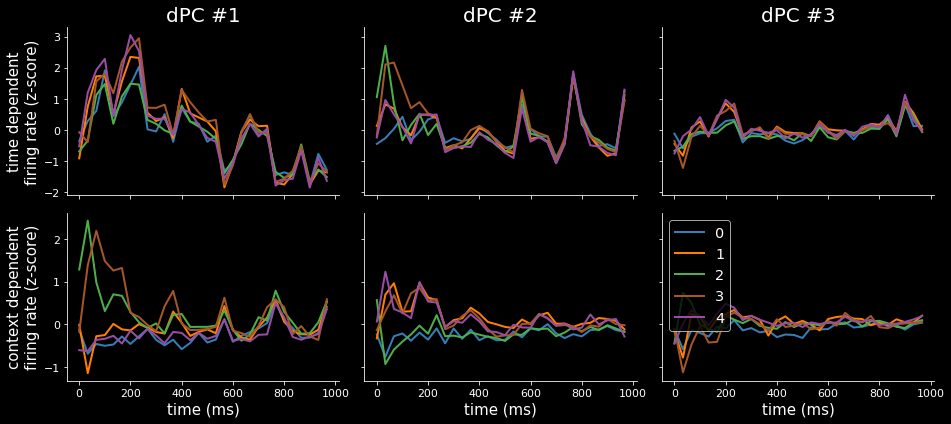

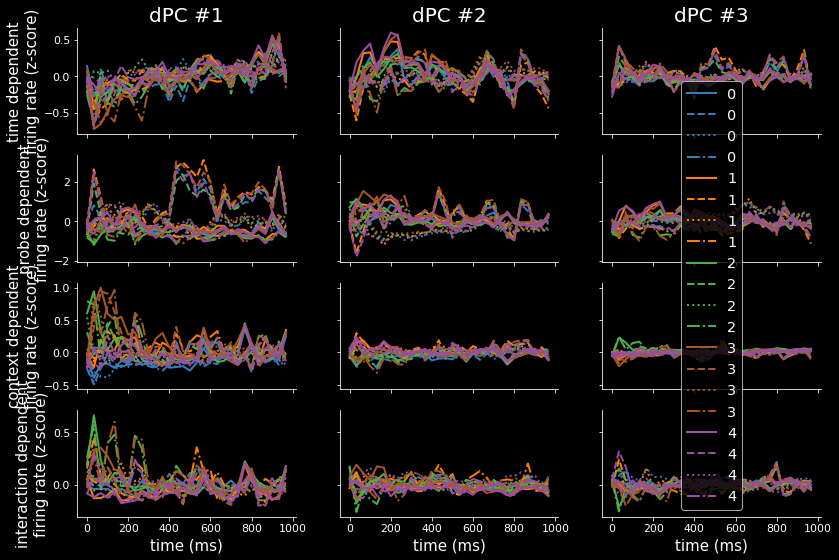

In [14]:
# probewise dPCA
fig1, axes, dpca = dPCA_site_summary(site, probe, 'pdPCA', ['t', 'ct'])
fig1.set_size_inches((13.33, 6))
title = f'{site} probe-{probe} dPCA projection'
# fig1.suptitle(title)
# fig1.tight_layout(rect=(0, 0, 1, 0.95))
# fplt.savefig(fig1, 'WIP4_figures', title, type='png')
plt.show()


# full dPCA
fig1, axes, dpca = dPCA_site_summary(site, probe, 'fdPCA', ['t', 'pt', 'ct', 'cpt'])
fig1.set_size_inches((13.33, 9))
title = f'{site} probe-{probe} dPCA projection'
# fig1.suptitle(title)
# fig1.tight_layout(rect=(0, 0, 1, 0.95))
# fplt.savefig(fig1, 'WIP4_figures', title, type='png')
plt.show()


# fig2, ax, inset = cdPCA.variance_explained(dpca, ax=None, names=['probe', 'context'], colors=['gray', 'green'],
#                                                   inset=False)
# fig2.set_size_inches((6, 3.6))
# title = f'{site} probe-{probe} dPCA variance explained'
# # _, labels, autotexts = inset
# # plt.setp(autotexts, size=15, weight='normal')
# # plt.setp(labels, size=15, weight='normal')
# # var_ax.set_title('marginalized variance')
# # fplt.savefig(fig2, 'WIP4_figures', title, type='png')
# plt.show()
#
#